# Trendbot — End‑to‑End Online Notebook (v1)

이 노트북은 **GitHub API → 정제/특징 생성 → 스코어링/랭킹 → 시각화/리포트** 전 과정을 한 번에 실행하도록 구성되어 있습니다.

- 실행 순서(권장): 상단부터 **Restart & Run All**
- 환경: 인터넷 가능 + GitHub Personal Access Token 필요
- 산출물: 셀 출력(표/그래프/마크다운) 위주 (필요 시 CSV 저장 라인 주석 해제)

---
**업데이트**: 2025-10-22 23:02 UTC


## 1) 의존성 설치

In [1]:
# 의존성 설치 (필요 시 1회만 실행)
# 주: Colab/새 환경에서만 필요. 이미 설치되어 있으면 몇 초 내 완료됩니다.
import sys, subprocess

def pip_install(pkgs):
    subprocess.run([sys.executable, "-m", "pip", "install", "-q"] + pkgs, check=False)

need = [
    "requests", "pandas", "numpy", "matplotlib", "scipy", "python-dotenv"
]
pip_install(need)

print("✅ dependencies ready")

✅ dependencies ready


## 2) 공통 임포트 & 경로 설정

In [2]:
import os, json, math, time, textwrap
from pathlib import Path
from datetime import datetime, timedelta, timezone
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from IPython.display import display, Markdown
import koreanize_matplotlib

# 경로 (노트북 디렉터리 기준)
ROOT = Path(".")
RAW   = ROOT/"data"/"raw"
CACHE = ROOT/"data"/"cache"
CLEAN = ROOT/"data"/"clean"
FEAT  = ROOT/"data"/"feature"
OUT   = ROOT/"data"/"output"
REPS  = ROOT/"reports"
FIGS  = ROOT/"figs"

for d in [RAW, CACHE, CLEAN, FEAT, OUT, REPS, FIGS]:
    d.mkdir(parents=True, exist_ok=True)

print("✅ paths ready")

✅ paths ready


## 3) GitHub 인증 (토큰 입력)

In [3]:
from getpass import getpass

# 환경변수로 설정되어 있으면 그대로 사용, 없으면 입력받기
GITHUB_TOKEN = os.environ.get("GITHUB_TOKEN") or getpass("Enter your GitHub Token: ")
session = requests.Session()
session.headers.update({
    "Authorization": f"Bearer {GITHUB_TOKEN}",
    "Accept": "application/vnd.github+json",
    "X-GitHub-Api-Version": "2022-11-28",
    "User-Agent": "trendbot-notebook"
})

# 간단한 로그인 확인
r = session.get("https://api.github.com/user")
r.raise_for_status()
login = r.json().get("login")
print(f"✅ GitHub 연결 OK — login: {login}")

✅ GitHub 연결 OK — login: northpard


## 4) 유틸 함수
gh_get: GitHub GET 호출의 표준 진입점(재시도+레이트리밋 대기).

search_repos: 검색 API를 페이징 수집해 레포 목록을 리턴.

safe_dt: 날짜 문자열을 UTC 타임스탬프로 안전 변환.

ok: 셀 진행상황을 👀 한눈에 보이게 표시.

In [4]:
# 역할: GitHub API용 GET 호출 유틸. 단순 재시도 + 레이트리밋(403) 대기까지 처리해 안정성을 높입니다.
def gh_get(url, params=None, max_retries=3, sleep=1.0):
    """GET with simple retry & rate limit handling."""
    # 최대 max_retries번 재시도 루프.
    for i in range(max_retries):
        # 전역의 requests.Session()(이전에 토큰/헤더 세팅된 객체)을 사용해 호출.
        resp = session.get(url, params=params, timeout=30)
        if resp.status_code == 403 and 'rate limit' in resp.text.lower():
            reset = resp.headers.get('X-RateLimit-Reset')
            wait_s = max(5, (int(reset) - int(time.time())) + 1) if reset else 10
            print(f"⏳ rate limited, sleeping {wait_s}s...")
            time.sleep(wait_s)
            continue
        try:
            resp.raise_for_status()
            return resp
        except requests.HTTPError:
            if i == max_retries - 1:
                raise
            time.sleep(sleep)
    return resp

# 역할: GitHub의 /search/repositories를 호출해 인기/조건 매칭 저장소를 여러 페이지에 걸쳐 수집하고, items 리스트(딕셔너리들)로 반환.
# 호출부에서 pages, per_page를 조정해 정확도 vs 속도/쿼터를 조절합니다.
# 이 함수는 가공하지 않은 원본 JSON 아이템을 그대로 반환 → 이후 단계에서 DataFrame으로 정규화.
def search_repos(q, sort="stars", order="desc", per_page=50, pages=1):
    """Search popular repositories by query. Returns list[dict]."""
    items = []
    # 루프: page를 1부터 pages까지 순회하며 gh_get으로 호출
    for page in range(1, pages+1):
        resp = gh_get("https://api.github.com/search/repositories", {
            # q: GitHub 검색 쿼리 문자열 (예: language:Python stars:>1000 pushed:>2025-09-01)
            "q": q, "sort": sort, "order": order, "per_page": per_page, "page": page
        })
        js = resp.json()
        # 반환값: list[dict] 형태의 저장소 개체들(필드 예: full_name, stargazers_count, forks_count, topics, created_at 등)
        items.extend(js.get("items", []))
        if len(js.get("items", [])) < per_page:
            break
    return items

# 역할: GitHub의 ISO8601 타임스탬프 문자열을 안전하게 pandas datetime(UTC, tz-aware) 으로 변환.
def safe_dt(s):
    if not s:
        return pd.NaT
    # GitHub ISO8601 => tz-aware UTC
    try:
        return pd.to_datetime(s, utc=True, errors="coerce")
    except Exception:
        return pd.NaT

# 역할: 노트북에서 진행 상황을 눈에 띄게 표시하는 간단한 UI 헬퍼.
def ok(msg): 
    display(Markdown("✅ " + msg))

print("✅ helpers ready")

✅ helpers ready


## 5) 데이터 수집 — 인기 저장소 검색

In [5]:
# ============================================================
# 🔀 통합 수집 셀: (A) 단일 QUERY  또는  (B) 토픽 다중 검색
# ------------------------------------------------------------
# - USE_TOPICS=False  → 기존 코드(단일 QUERY) 그대로 동작
# - USE_TOPICS=True   → AI/ML/ROBOT 등 영문 토픽 기반 다중 검색(언어 제한 없음)
# ============================================================

# ===== (공통) 파라미터 =====
PAGES   = 2      # 검색 페이지(×50개/페이지)
TOP_N   = 60     # 상위 N개만 사용 (과도한 API 소모 방지)

# ===== 모드 스위치 =====
USE_TOPICS = True   # ➜ False면 기존 QUERY 모드

# ===== (A) 단일 QUERY 모드 파라미터 =====
QUERY = "language:Python stars:>1000"   # 필요 시 변경

# ===== (B) 토픽 다중 검색 모드 파라미터 =====
# TOPICS = [
#     "ai","artificial-intelligence","machine-learning","deep-learning","ml",
#     "neural-network","transformer","llm","large-language-model","generative-ai",
#     "rag","robotics","autonomous","computer-vision","nlp","embodied-ai",
#     "agent","reinforcement-learning","control",
# ]
TOPICS = ["robotics", "ROS", "robot arm", "robot", "amr"]

STARS_THRESHOLD = 1000         # 최소 스타 수
RECENT_DAYS     = 60           # 최근성(며칠 이내 push)
from datetime import datetime, timedelta, timezone
since_dt   = datetime.now(timezone.utc) - timedelta(days=RECENT_DAYS)
RECENT_SINCE = since_dt.date().isoformat()   # e.g., '2025-08-24'

# ===== 정규화 함수(원본 유지) =====
def to_row(o):
    return {
        "id": o.get("id"),
        "full_name": o.get("full_name"),
        "description": o.get("description"),
        "language": o.get("language"),
        "stargazers_count": o.get("stargazers_count", 0),
        "forks_count": o.get("forks_count", 0),
        "open_issues_count": o.get("open_issues_count", 0),
        "created_at": safe_dt(o.get("created_at")),
        "updated_at": safe_dt(o.get("updated_at")),
        "topics": ",".join(o.get("topics", [])),
        "fork": bool(o.get("fork", False)),
    }

# ===== 수집 실행 =====
all_rows = []

if not USE_TOPICS:
    # ---------- (A) 기존: 단일 QUERY ----------
    print(f"🔎 검색: {QUERY} | pages={PAGES}")
    items = search_repos(QUERY, per_page=50, pages=PAGES)
    items = items[:TOP_N]
    print(f"→ 수집 {len(items)} repos")
    rows = [to_row(x) for x in items]
    for r in rows:
        r["query_source"] = QUERY
    all_rows.extend(rows)

else:
    # ---------- (B) 토픽 다중 검색 ----------
    print(f"🚀 토픽 기반 검색 시작 ({len(TOPICS)}개 토픽, stars>{STARS_THRESHOLD}, pushed>={RECENT_SINCE})")
    for topic in TOPICS:
        q = f"topic:{topic} stars:>{STARS_THRESHOLD} pushed:>={RECENT_SINCE}"
        print(f"  🔎 {q}")
        items = search_repos(q, per_page=50, pages=1)  # 토픽당 1페이지(최대 50개) 권장
        if not items:
            print(f"  ⚠️ 결과 없음: {topic}")
            continue
        items = items[: min(TOP_N, 50)]
        rows = [to_row(x) for x in items]
        for r in rows:
            r["query_source"] = f"topic:{topic}"
        all_rows.extend(rows)
        print(f"  ✅ {topic}: {len(rows)}개")

# ===== DataFrame 구성 & 기본 정제 =====
base = pd.DataFrame(all_rows) if all_rows else pd.DataFrame(columns=[
    "id","full_name","description","language","stargazers_count","forks_count",
    "open_issues_count","created_at","updated_at","topics","fork","query_source"
])

# 중복 제거(여러 쿼리/토픽에서 중복 등장할 수 있음)
base.drop_duplicates(subset=["full_name"], inplace=True)

# 포크 제외(원본 중심 분석) — 필요 시 이 줄을 주석 처리해서 포함 가능
if "fork" in base.columns:
    base = base[base["fork"] == False]

# 언어 결측 처리
if "language" in base.columns:
    base["language"].fillna("Unknown", inplace=True)

# ===== 결과 확인 =====
ok(f"기본 저장소 목록 준비 — 총 {len(base)}개")
display(base.head(10))


🚀 토픽 기반 검색 시작 (5개 토픽, stars>1000, pushed>=2025-08-24)
  🔎 topic:robotics stars:>1000 pushed:>=2025-08-24
  ✅ robotics: 50개
  🔎 topic:ROS stars:>1000 pushed:>=2025-08-24
  ✅ ROS: 21개
  🔎 topic:robot arm stars:>1000 pushed:>=2025-08-24
  ✅ robot arm: 1개
  🔎 topic:robot stars:>1000 pushed:>=2025-08-24
  ✅ robot: 13개
  🔎 topic:amr stars:>1000 pushed:>=2025-08-24
  ✅ amr: 2개


/tmp/ipykernel_13098/1926457043.py:95: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base["language"].fillna("Unknown", inplace=True)


✅ 기본 저장소 목록 준비 — 총 74개

,id,full_name,description,language,stargazers_count,forks_count,open_issues_count,created_at,updated_at,topics,fork,query_source
0,71583602,Developer-Y/cs-video-courses,List of Computer Science courses with video le...,Unknown,70095,9413,2,2016-10-21 17:02:11+00:00,2025-10-23 06:07:04+00:00,"algorithms,bioinformatics,computational-biolog...",False,topic:robotics
1,74627617,commaai/openpilot,openpilot is an operating system for robotics....,Python,58485,10341,184,2016-11-24 01:33:30+00:00,2025-10-23 06:20:53+00:00,"advanced-driver-assistance-systems,driver-assi...",False,topic:robotics
2,280567579,NaiboWang/EasySpider,A visual no-code/code-free web crawler/spider易...,JavaScript,43138,5302,253,2020-07-18 02:41:27+00:00,2025-10-23 06:00:29+00:00,"batch-processing,batch-script,code-free,crawle...",False,topic:robotics
3,54376220,AtsushiSakai/PythonRobotics,Python sample codes and textbook for robotics ...,Python,26101,6909,20,2016-03-21 09:34:43+00:00,2025-10-23 06:18:49+00:00,"algorithm,animation,autonomous-driving,autonom...",False,topic:robotics
4,365250183,zauberzeug/nicegui,Create web-based user interfaces with Python. ...,Python,14283,846,89,2021-05-07 13:55:05+00:00,2025-10-23 04:05:10+00:00,"frontend,gui,interaction,interface,interfaces,...",False,topic:robotics
5,7512484,ArduPilot/ardupilot,"ArduPlane, ArduCopter, ArduRover, ArduSub source",C++,13918,19560,2713,2013-01-09 00:58:52+00:00,2025-10-23 04:54:38+00:00,"arducopter,ardupilot,arduplane,ardurover,ardus...",False,topic:robotics
6,1605598,bulletphysics/bullet3,Bullet Physics SDK: real-time collision detect...,C++,13844,3001,386,2011-04-12 18:45:08+00:00,2025-10-22 16:25:25+00:00,"computer-animation,game-development,kinematics...",False,topic:robotics
7,261372860,DLR-RM/stable-baselines3,"PyTorch version of Stable Baselines, reliable ...",Python,11836,1963,74,2020-05-05 05:52:26+00:00,2025-10-23 00:18:56+00:00,"baselines,gsde,gym,machine-learning,openai,pyt...",False,topic:robotics
8,400501136,google-deepmind/mujoco,Multi-Joint dynamics with Contact. A general p...,C++,10902,1158,207,2021-08-27 12:25:48+00:00,2025-10-23 05:42:51+00:00,"mujoco,physics,robotics",False,topic:robotics
9,145693916,kornia/kornia,🐍 Geometric Computer Vision Library for Spatia...,Python,10802,1060,337,2018-08-22 10:31:37+00:00,2025-10-23 03:50:01+00:00,"artificial-intelligence,computer-vision,deep-l...",False,topic:robotics


### matplotlib 사용, 각 그래프 생성
Language 분포: 어떤 언어가 많이 쓰였는지 규모 파악

Stars 분포(log): 상위 몇 개가 몰려 있는지(롱테일) 확인

Forks vs Stars: 프로젝트 확산성(포크)과 인기도(스타)의 관계

Open Issues vs Stars: 인기 대비 이슈 부담(유지보수 난이도) 감지

Created Year: 생성 연도 트렌드(최근 창업/출시 붐)

Query Source: 어떤 토픽/검색조건에서 많이 나왔는지

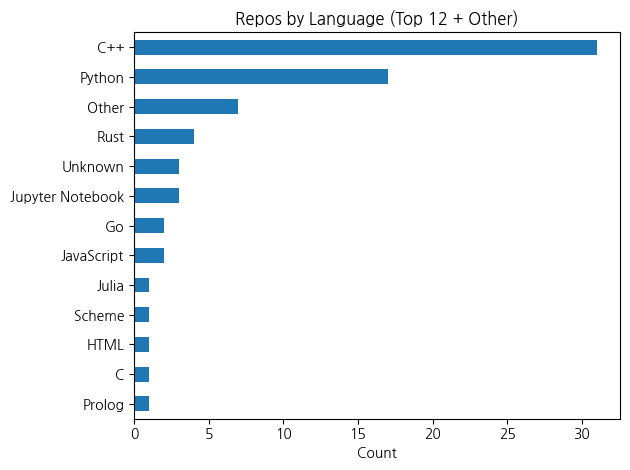

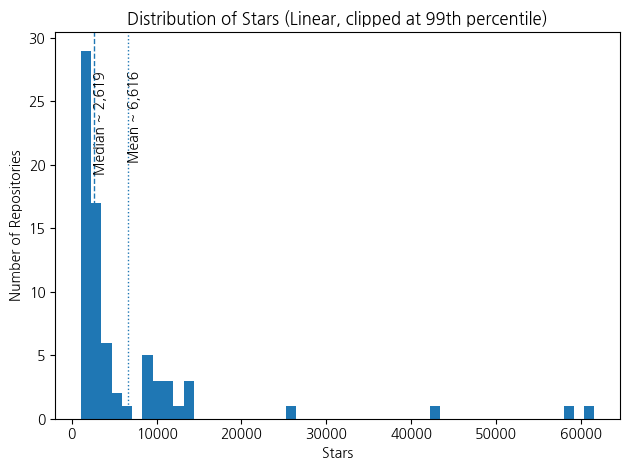

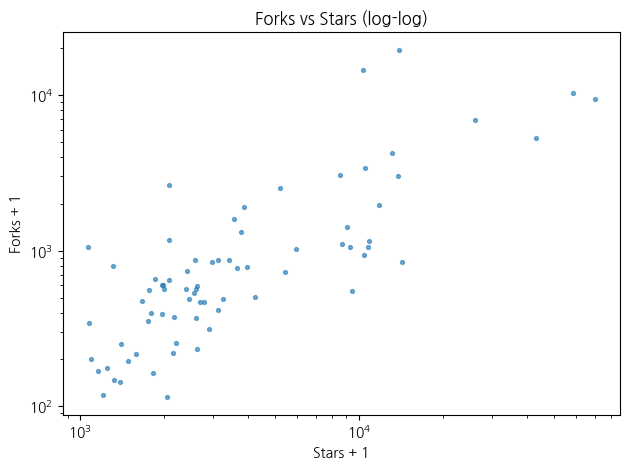

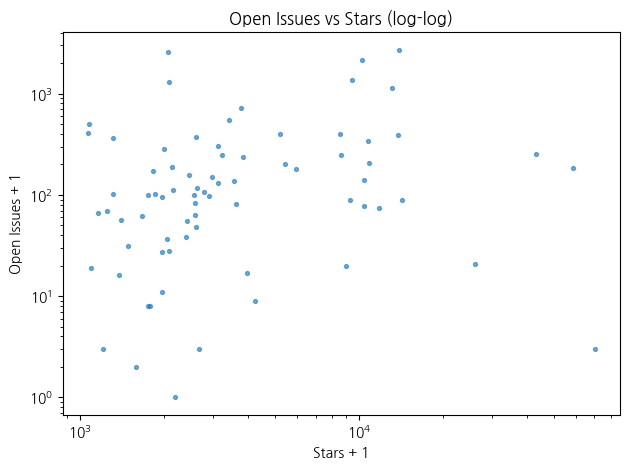

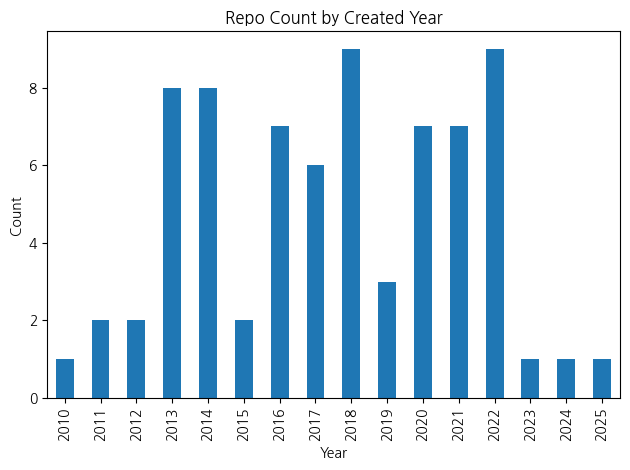

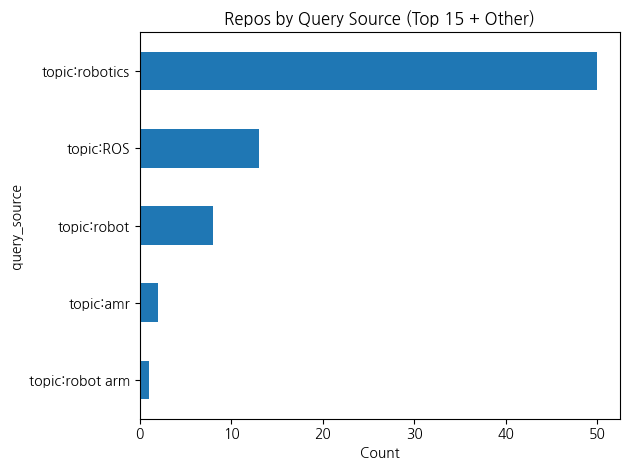

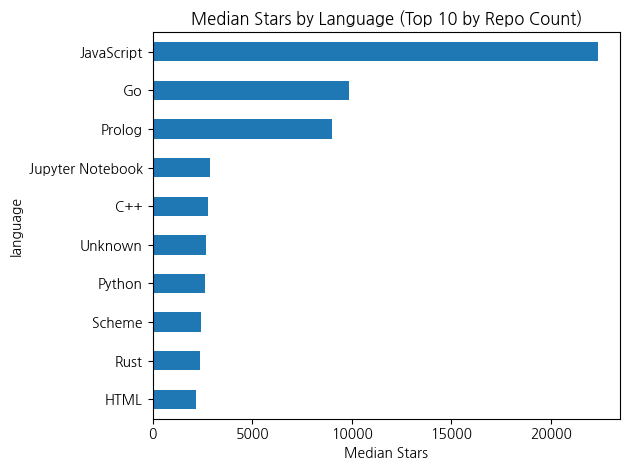

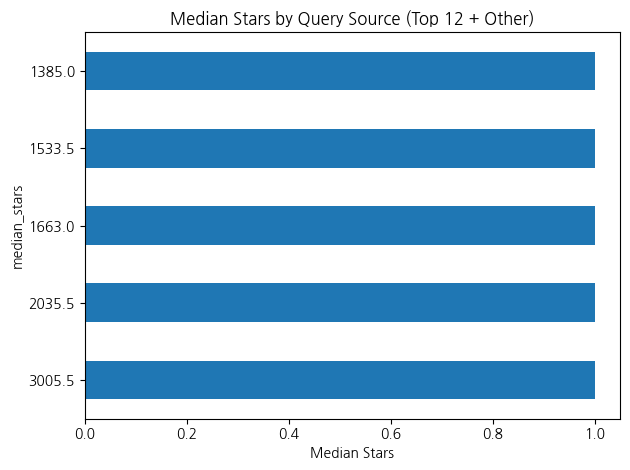

,total_repos,languages_unique,query_sources_unique,stars_median,stars_mean,forks_median,open_issues_median
0,74,19,5,2619.0,6730.864865,626.5,101.0


,repos,stars_median,stars_mean
language,,,
C++,31,2780.0,4331.548387
Python,17,2615.0,8942.058824
Rust,4,2383.0,3862.250000
Jupyter Notebook,3,2895.0,2803.333333
Unknown,3,2680.0,24660.000000
JavaScript,2,22359.5,22359.500000
Go,2,9860.5,9860.500000
C#,1,2079.0,2079.000000
C,1,1961.0,1961.000000


,repos,stars_median
query_source,,
topic:robotics,50,3005.5
topic:ROS,13,1663.0
topic:robot,8,1533.5
topic:amr,2,2035.5
topic:robot arm,1,1385.0


In [6]:
# ============================================================
# 📊 base로 의미 있는 분석 그래프 (로그 OFF 기본, 옵션 토글)
# - Language 분포/언어별 Stars 중앙값
# - Stars 분포 (선형 기본, p99 클리핑 + 중앙값/평균선)
# - (옵션) Stars 분포 (log10)
# - Forks vs Stars (log-log)
# - Open Issues vs Stars (log-log)
# - Created Year 분포
# - Query Source 분포
# - (추가) Query Source별 Median Stars
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- 옵션 스위치 ----
SHOW_LINEAR_STARS = True     # 선형 히스토그램 표시 (기본)
SHOW_LOG_STARS    = False    # 로그 히스토그램 추가로 표시할지

# --- 안전 가드: 필요한 컬럼 체크 ---
required = {"full_name","language","stargazers_count","forks_count","open_issues_count","created_at","query_source"}
missing = required - set(base.columns)
assert not missing, f"base에 필요한 컬럼이 없습니다: {missing}"

# --- 정리 ---
df = base.copy()
for c in ["stargazers_count","forks_count","open_issues_count"]:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)

df["created_at"] = pd.to_datetime(df["created_at"], errors="coerce", utc=True)
df["language"] = df["language"].fillna("Unknown").replace("", "Unknown")
if "query_source" not in df.columns:
    df["query_source"] = "(unknown)"
df["query_source"] = df["query_source"].fillna("(unknown)")

def top_with_other(s: pd.Series, top_n=12, other="Other"):
    vc = s.value_counts(dropna=False)
    if len(vc) <= top_n:
        return vc
    return pd.concat([vc.iloc[:top_n], pd.Series({other: vc.iloc[top_n:].sum()})])

# 1) Language 분포 (Top 12 + Other)
lang_counts = top_with_other(df["language"], top_n=12)
plt.figure()
lang_counts.sort_values().plot(kind="barh")
plt.title("Repos by Language (Top 12 + Other)")
plt.xlabel("Count")
plt.tight_layout()
plt.show()

# 2) Stars 분포 (선형, 상위 1% 클리핑 + 중앙값/평균선)
if SHOW_LINEAR_STARS:
    p99 = df["stargazers_count"].quantile(0.99)  # 극단치 꼬리 잘라 시각화 안정화
    stars_clip = df["stargazers_count"].clip(upper=p99)
    median_val = float(stars_clip.median())
    mean_val   = float(stars_clip.mean())

    plt.figure()
    plt.hist(stars_clip, bins=50)
    plt.title("Distribution of Stars (Linear, clipped at 99th percentile)")
    plt.xlabel("Stars")
    plt.ylabel("Number of Repositories")
    # 중앙값/평균 보조선
    plt.axvline(median_val, linestyle="--", linewidth=1)
    plt.text(median_val, plt.ylim()[1]*0.9, f"Median ~ {int(median_val):,}", rotation=90, va="top")
    plt.axvline(mean_val, linestyle=":", linewidth=1)
    plt.text(mean_val, plt.ylim()[1]*0.9, f"Mean ~ {int(mean_val):,}", rotation=90, va="top")
    plt.tight_layout()
    plt.show()

# (옵션) 2-1) Stars 분포 (log10)
if SHOW_LOG_STARS:
    log_stars = np.log10(df["stargazers_count"].astype(float) + 1.0)
    plt.figure()
    plt.hist(log_stars, bins=30)
    plt.title("Distribution of log10(Stars + 1)")
    plt.xlabel("log10(stars + 1)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# 3) Forks vs Stars (log-log)
plt.figure()
plt.scatter(df["stargazers_count"].astype(float) + 1.0,
            df["forks_count"].astype(float) + 1.0, s=8, alpha=0.6)
plt.xscale("log"); plt.yscale("log")
plt.title("Forks vs Stars (log-log)")
plt.xlabel("Stars + 1"); plt.ylabel("Forks + 1")
plt.tight_layout()
plt.show()

# 4) Open Issues vs Stars (log-log)
plt.figure()
plt.scatter(df["stargazers_count"].astype(float) + 1.0,
            df["open_issues_count"].astype(float) + 1.0, s=8, alpha=0.6)
plt.xscale("log"); plt.yscale("log")
plt.title("Open Issues vs Stars (log-log)")
plt.xlabel("Stars + 1"); plt.ylabel("Open Issues + 1")
plt.tight_layout()
plt.show()

# 5) Created_at 연도 분포
year_counts = df["created_at"].dt.year.dropna().value_counts().sort_index()
plt.figure()
year_counts.plot(kind="bar")
plt.title("Repo Count by Created Year")
plt.xlabel("Year"); plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 6) Query Source 분포 (Top 15 + Other)
qs_counts = top_with_other(df["query_source"], top_n=15)
plt.figure()
qs_counts.sort_values().plot(kind="barh")
plt.title("Repos by Query Source (Top 15 + Other)")
plt.xlabel("Count")
plt.tight_layout()
plt.show()

# 7) 언어별 Stars 중앙값 (Top 10 언어 기준)
top_langs = df["language"].value_counts().head(10).index.tolist()
med_stars_by_lang = (df[df["language"].isin(top_langs)]
                     .groupby("language")["stargazers_count"]
                     .median()
                     .sort_values())
plt.figure()
med_stars_by_lang.plot(kind="barh")
plt.title("Median Stars by Language (Top 10 by Repo Count)")
plt.xlabel("Median Stars")
plt.tight_layout()
plt.show()

# 8) (추가) Query Source별 Median Stars (Top 12)
qs_med = (df.groupby("query_source")["stargazers_count"]
            .median()
            .sort_values(ascending=False))
qs_med = top_with_other(qs_med.rename("median_stars"), top_n=12)
plt.figure()
qs_med.sort_values().plot(kind="barh")
plt.title("Median Stars by Query Source (Top 12 + Other)")
plt.xlabel("Median Stars")
plt.tight_layout()
plt.show()

# (옵션) 간단 요약 테이블 출력
summary = {
    "total_repos": len(df),
    "languages_unique": df["language"].nunique(),
    "query_sources_unique": df["query_source"].nunique(),
    "stars_median": float(df["stargazers_count"].median()),
    "stars_mean": float(df["stargazers_count"].mean()),
    "forks_median": float(df["forks_count"].median()),
    "open_issues_median": float(df["open_issues_count"].median()),
}
display(pd.DataFrame([summary]))

display(
    (df.groupby("language")
       .agg(repos=("full_name","count"),
            stars_median=("stargazers_count","median"),
            stars_mean=("stargazers_count","mean"))
       .sort_values("repos", ascending=False)
       .head(15))
)

display(
    (df.groupby("query_source")
       .agg(repos=("full_name","count"),
            stars_median=("stargazers_count","median"))
       .sort_values("repos", ascending=False)
       .head(15))
)


## 6) 보조 데이터(Commits/Issues/PRs) 수집 — 상위 K개만
인기 상위(별 수 기준) 15개 저장소에 대해 보조 지표(활동량·이슈·PR·기여자 수 등) 를 GitHub API로 수집

### 각 저장소(full_name 1개)에 대해 실행하는 API 호출
| 구분 | 엔드포인트                  | 반복                        | 최대 요청 수 |
| -- | ---------------------- | ------------------------- | ------- |
| 1  | `/commits`             | `paged_count()` → 최대 2페이지 | 2회      |
| 2  | `/issues` (전체)         | `paged_count()` → 최대 2페이지 | 2회      |
| 3  | `/issues?state=closed` | `count_closed()` → 1페이지   | 1회      |
| 4  | `/pulls` (전체)          | `paged_count()` → 최대 2페이지 | 2회      |
| 5  | `/pulls?state=closed`  | `count_closed()` → 1페이지   | 1회      |
| 6  | `/contributors`        | 1페이지 (최대 100명)            | 1회      |


### 각 저장소마다 실행되는 API 요약 👇
| API 엔드포인트              | 내용             | 함수             | 결과 변수                          |
| ---------------------- | -------------- | -------------- | ------------------------------ |
| `/commits`             | 최근 1년간 커밋 수    | `paged_count`  | `commits`                      |
| `/issues`              | 최근 1년간 이슈 총 수  | `paged_count`  | `issues_total`                 |
| `/issues?state=closed` | 닫힌 이슈 수        | `count_closed` | `issues_closed`                |
| `/pulls`               | PR 총 수         | `paged_count`  | `pulls_total`                  |
| `/pulls?state=closed`  | 닫힌/병합된 PR 수    | `count_closed` | `pulls_closed`, `pulls_merged` |
| `/contributors`        | 기여자 수(최대 100명) | `gh_get` 직접 호출 | `unique_contrib`               |


In [7]:
# 핵심 제어 변수
# 15건 선정기준 
#============================
# --- 안전 가드: base가 DataFrame인지 확인/복구 ---
import pandas as pd
import numpy as np

# 1) 타입 확인
if not isinstance(base, pd.DataFrame):
    raise TypeError(f"`base`가 DataFrame이 아닙니다. 현재 타입: {type(base)}\n"
                    f"이전 셀(검색/정규화)부터 다시 실행해서 base를 재생성하세요.")

# 2) 필수 컬럼 확인
required_cols = {"full_name", "stargazers_count"}
missing = required_cols - set(base.columns)
if missing:
    raise KeyError(f"`base`에 필요한 컬럼이 없습니다: {missing}\n"
                   f"정규화(to_row) 셀과 base 생성 셀부터 다시 실행하세요.")

# 3) NaN 정리(별 수가 NaN이면 정렬/랭킹에 문제)
base["stargazers_count"] = pd.to_numeric(base["stargazers_count"], errors="coerce").fillna(0).astype(int)

# 4) 상위 N개(별 수 기준) 안전하게 뽑기
AUX_TOP = min(15, len(base))
top_full_names = base.nlargest(AUX_TOP, "stargazers_count")["full_name"].tolist()

#============================
SINCE_DAYS = 365                # 최근 1년
PAGES_COMMITS = 2               # 각 리소스당 최대 2페이지 × 100 = 200개

cutoff = (datetime.now(timezone.utc) - timedelta(days=SINCE_DAYS)).isoformat()

# 목적: 페이징 가능한 API(커밋, 이슈, PR 등)에서 총 개수를 구함.
# 페이지에 100건씩 요청, 최대 2페이지(=200건).
# 응답이 리스트가 아니거나 100건 미만이면 중단.
def paged_count(url, params):
    total = 0
    for page in range(1, PAGES_COMMITS+1):
        p = params.copy()
        p.update({"per_page": 100, "page": page})
        r = gh_get(url, p)
        arr = r.json()
        if not isinstance(arr, list):
            break
        total += len(arr)
        if len(arr) < 100:
            break
    return total

# 목적: 닫힌 항목(이슈 or PR) 개수를 빠르게 추정.
# 1페이지만 보고 state=closed 조건으로 호출.
# PR일 경우 merged_at 여부로 병합된 PR 수도 추정.
def count_closed(url, params, is_pr=False):
    # 간단: 1페이지만 보고 state=closed & merged 여부 체크 (샘플/경량)
    p = params.copy()
    p.update({"per_page": 100, "page": 1, "state": "closed"})
    r = gh_get(url, p); arr = r.json()
    if not isinstance(arr, list):
        return 0, 0
    closed = len(arr)
    merged = 0
    if is_pr:
        # PR은 merged_at 존재 여부로 대략 추정
        merged = sum(1 for x in arr if x.get("merged_at"))
    return closed, merged

aux_rows = []
for full in top_full_names:
    owner, repo = full.split("/", 1)
    print("→ aux fetch:", full)

    commits = paged_count(f"https://api.github.com/repos/{owner}/{repo}/commits", {"since": cutoff})
    issues_total = paged_count(f"https://api.github.com/repos/{owner}/{repo}/issues", {"since": cutoff, "state": "all"})
    issues_closed, _ = count_closed(f"https://api.github.com/repos/{owner}/{repo}/issues", {"since": cutoff}, is_pr=False)

    pulls_total = paged_count(f"https://api.github.com/repos/{owner}/{repo}/pulls", {"state": "all"})
    pulls_closed, pulls_merged = count_closed(f"https://api.github.com/repos/{owner}/{repo}/pulls", {}, is_pr=True)

    unique_contrib = 0
    try:
        r = gh_get(f"https://api.github.com/repos/{owner}/{repo}/contributors", {"per_page": 100})
        arr = r.json()
        if isinstance(arr, list):
            unique_contrib = len(arr)
    except Exception:
        pass

    aux_rows.append({
        "full_name": full,
        "activity_12m": commits,
        "contributors_12m": unique_contrib,
        "issues_total": issues_total,
        "issues_closed": issues_closed,
        "pulls_total": pulls_total,
        "pulls_closed": pulls_closed,
        "pulls_merged": pulls_merged,
    })

# 모든 결과를 딕셔너리로 모아 aux_rows에 추가 → 최종적으로 df_aux 생성.
df_aux = pd.DataFrame(aux_rows)
ok("보조 지표 수집 완료") 
display(df_aux.head())

→ aux fetch: Developer-Y/cs-video-courses
→ aux fetch: commaai/openpilot
→ aux fetch: NaiboWang/EasySpider
→ aux fetch: AtsushiSakai/PythonRobotics
→ aux fetch: zauberzeug/nicegui
→ aux fetch: ArduPilot/ardupilot
→ aux fetch: bulletphysics/bullet3
→ aux fetch: carla-simulator/carla
→ aux fetch: DLR-RM/stable-baselines3
→ aux fetch: google-deepmind/mujoco
→ aux fetch: kornia/kornia
→ aux fetch: autowarefoundation/autoware
→ aux fetch: go-vgo/robotgo
→ aux fetch: PX4/PX4-Autopilot
→ aux fetch: rerun-io/rerun


✅ 보조 지표 수집 완료

,full_name,activity_12m,contributors_12m,issues_total,issues_closed,pulls_total,pulls_closed,pulls_merged
0,Developer-Y/cs-video-courses,105,100,91,91,200,100,97
1,commaai/openpilot,200,100,200,100,200,100,72
2,NaiboWang/EasySpider,77,8,200,100,74,69,42
3,AtsushiSakai/PythonRobotics,163,100,200,100,200,100,86
4,zauberzeug/nicegui,200,100,200,100,200,100,81


## 7) Feature Engineering & 병합

In [8]:
def recent_push_90d(ts):
    if pd.isna(ts):
        return False
    return (pd.Timestamp.now(tz=timezone.utc) - ts).days <= 90

df = base.copy()
if not df_aux.empty:
    df = df.merge(df_aux, on="full_name", how="left")
else:
    # 보조가 비면 0 할당
    for c in ["activity_12m","contributors_12m","issues_total","issues_closed","pulls_total","pulls_closed","pulls_merged"]:
        df[c] = 0

df["recent_push_90d"] = df["updated_at"].apply(recent_push_90d)

def safe_rate(numer, denom):
    numer = numer.fillna(0)
    denom = denom.fillna(0)
    with np.errstate(divide='ignore', invalid='ignore'):
        r = np.where(denom>0, numer/denom, 0.0)
    return pd.Series(r, index=numer.index, dtype=float)

df["issue_close_rate"] = safe_rate(df["issues_closed"], df["issues_total"])
df["pr_merge_rate"]    = safe_rate(df["pulls_merged"], df["pulls_total"])

ok("Feature 병합/계산 완료") 
display(df.head())

✅ Feature 병합/계산 완료

,id,full_name,description,language,stargazers_count,forks_count,open_issues_count,created_at,updated_at,topics,...,activity_12m,contributors_12m,issues_total,issues_closed,pulls_total,pulls_closed,pulls_merged,recent_push_90d,issue_close_rate,pr_merge_rate
0,71583602,Developer-Y/cs-video-courses,List of Computer Science courses with video le...,Unknown,70095,9413,2,2016-10-21 17:02:11+00:00,2025-10-23 06:07:04+00:00,"algorithms,bioinformatics,computational-biolog...",...,105.0,100.0,91.0,91.0,200.0,100.0,97.0,True,1.0,0.485000
1,74627617,commaai/openpilot,openpilot is an operating system for robotics....,Python,58485,10341,184,2016-11-24 01:33:30+00:00,2025-10-23 06:20:53+00:00,"advanced-driver-assistance-systems,driver-assi...",...,200.0,100.0,200.0,100.0,200.0,100.0,72.0,True,0.5,0.360000
2,280567579,NaiboWang/EasySpider,A visual no-code/code-free web crawler/spider易...,JavaScript,43138,5302,253,2020-07-18 02:41:27+00:00,2025-10-23 06:00:29+00:00,"batch-processing,batch-script,code-free,crawle...",...,77.0,8.0,200.0,100.0,74.0,69.0,42.0,True,0.5,0.567568
3,54376220,AtsushiSakai/PythonRobotics,Python sample codes and textbook for robotics ...,Python,26101,6909,20,2016-03-21 09:34:43+00:00,2025-10-23 06:18:49+00:00,"algorithm,animation,autonomous-driving,autonom...",...,163.0,100.0,200.0,100.0,200.0,100.0,86.0,True,0.5,0.430000
4,365250183,zauberzeug/nicegui,Create web-based user interfaces with Python. ...,Python,14283,846,89,2021-05-07 13:55:05+00:00,2025-10-23 04:05:10+00:00,"frontend,gui,interaction,interface,interfaces,...",...,200.0,100.0,200.0,100.0,200.0,100.0,81.0,True,0.5,0.405000


## 8) 표준화(z-score) & 가중합 스코어링

In [9]:
score_cols = ["activity_12m","contributors_12m","issue_close_rate","pr_merge_rate","stargazers_count"]
scored = df.copy()
for c in score_cols:
    scored[f"{c}_z"] = zscore(scored[c].fillna(0)) if scored[c].std() not in (0, np.nan) else 0.0

weights = {
    "activity_12m_z": 0.25,
    "contributors_12m_z": 0.25,
    "issue_close_rate_z": 0.20,
    "pr_merge_rate_z": 0.15,
    "stargazers_count_z": 0.15,
}
scored["score"] = sum(scored[k]*w for k, w in weights.items())
ranked = scored.sort_values("score", ascending=False).reset_index(drop=True)

ok("스코어링 & 랭킹 완료") 
display(ranked.head(10)[["full_name","language","stargazers_count","activity_12m","contributors_12m","issue_close_rate","pr_merge_rate","score"]])

✅ 스코어링 & 랭킹 완료

,full_name,language,stargazers_count,activity_12m,contributors_12m,issue_close_rate,pr_merge_rate,score
0,Developer-Y/cs-video-courses,Unknown,70095,105.0,100.0,1.0,0.485,2.813737
1,commaai/openpilot,Python,58485,200.0,100.0,0.5,0.360,2.476259
2,AtsushiSakai/PythonRobotics,Python,26101,163.0,100.0,0.5,0.430,1.973486
3,zauberzeug/nicegui,Python,14283,200.0,100.0,0.5,0.405,1.939387
4,rerun-io/rerun,Rust,9437,200.0,100.0,0.5,0.455,1.920182
5,PX4/PX4-Autopilot,C++,10301,200.0,100.0,0.5,0.430,1.909453
6,ArduPilot/ardupilot,C++,13918,200.0,100.0,0.5,0.365,1.899432
7,carla-simulator/carla,C++,13150,157.0,100.0,0.5,0.430,1.781552
8,kornia/kornia,Python,10802,156.0,100.0,0.5,0.405,1.725095
9,google-deepmind/mujoco,C++,10902,200.0,88.0,0.5,0.265,1.691011


## 9) 시각화 — 스타 분포 & 연도별 추이

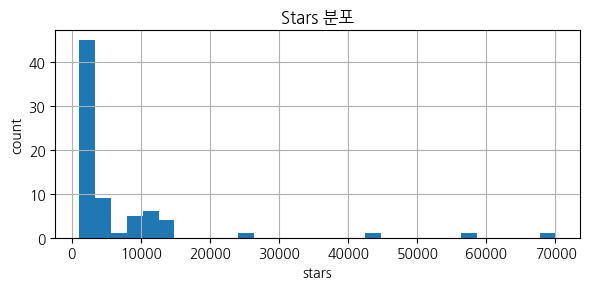

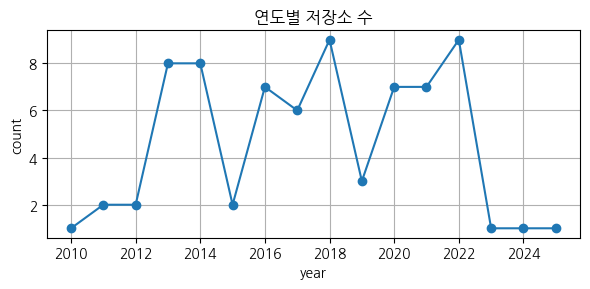

In [10]:
# 스타 분포
plt.figure(figsize=(6,3))
plt.hist(scored["stargazers_count"].dropna(), bins=30)
plt.title("Stars 분포"); plt.xlabel("stars"); plt.ylabel("count"); plt.grid(True); plt.tight_layout(); plt.show()

# 연도별 생성 수
if "created_at" in scored.columns:
    created_year = scored["created_at"].dropna().dt.tz_convert("UTC").dt.year
    grp = created_year.value_counts().sort_index()
    if len(grp) > 0:
        plt.figure(figsize=(6,3))
        plt.plot(grp.index, grp.values, marker="o")
        plt.title("연도별 저장소 수"); plt.xlabel("year"); plt.ylabel("count"); plt.grid(True); plt.tight_layout(); plt.show()

## 10) 레이더 & 타임라인(경량)

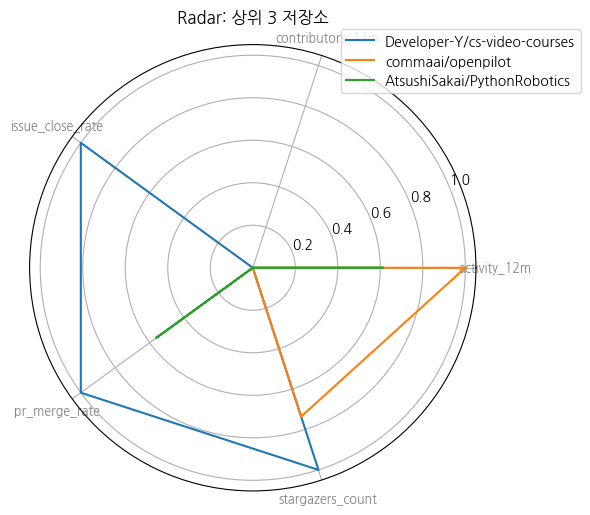

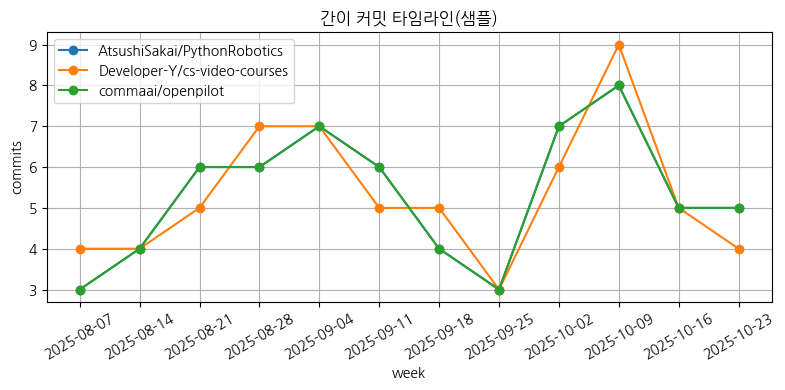

,full_name,score
0,Developer-Y/cs-video-courses,2.813737
1,commaai/openpilot,2.476259
2,AtsushiSakai/PythonRobotics,1.973486


In [11]:
top3 = ranked.head(3).copy()
features = ["activity_12m","contributors_12m","issue_close_rate","pr_merge_rate","stargazers_count"]

def normalize(s: pd.Series) -> pd.Series:
    s = pd.to_numeric(s, errors="coerce").fillna(0)
    vmax, vmin = float(s.max()), float(s.min())
    if vmax == vmin:
        return pd.Series(0.0, index=s.index)
    return (s - vmin) / (vmax - vmin)

top3_norm = top3.copy()
top3_norm[features] = top3[features].apply(normalize)

# Radar
import numpy as np
labels = np.array(features)
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(6,6))
for _, row in top3_norm.iterrows():
    vals = row[features].tolist(); vals += vals[:1]
    plt.polar(angles, vals, label=row["full_name"])
plt.xticks(angles[:-1], labels, color="gray", size=9)
plt.title("Radar: 상위 3 저장소"); plt.legend(bbox_to_anchor=(1.25,1.05))
plt.tight_layout(); plt.show()

# Timeline (샘플: 주 12개 생성, repo별 변동 패턴 다르게)
weeks = 12
week_labels = pd.date_range(end=pd.Timestamp.today(), periods=weeks, freq="7D").strftime("%Y-%m-%d").tolist()
frames = []
for r in top3["full_name"].tolist():
    seed = abs(hash(r)) % 7
    base = np.array([3,4,5,6,7,5,4,3,6,8,5,4], dtype=float)[:weeks]
    noise = ((seed + np.arange(weeks)) % 3) * 0.7
    counts = np.clip(base + noise, 0, None).astype(int)
    frames.append(pd.DataFrame({"repo": r, "week": week_labels, "commit_count": counts}))

timeline = pd.concat(frames, ignore_index=True)

plt.figure(figsize=(8,4))
for name, g in timeline.groupby("repo"):
    plt.plot(g["week"], g["commit_count"], marker="o", label=name)
plt.xticks(rotation=30)
plt.title("간이 커밋 타임라인(샘플)"); plt.xlabel("week"); plt.ylabel("commits"); plt.grid(True); plt.legend()
plt.tight_layout(); plt.show()

display(top3[["full_name","score"]])

## 11) 품질 루브릭(간단/오프라인 휴리스틱)

<Figure size 900x500 with 0 Axes>

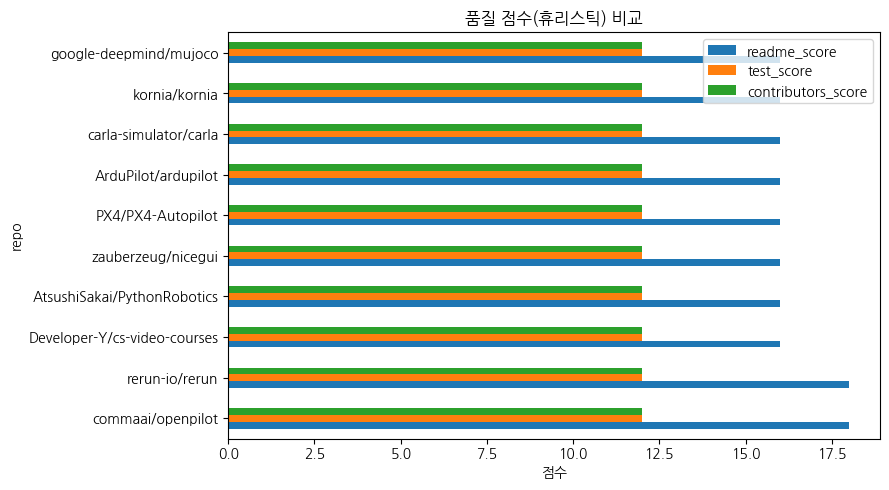

,repo,readme_score,test_score,doc_score,contributors_score,activity_score,license_score,ci_score,total
1,commaai/openpilot,18,12,12,12,12,10,5,81
4,rerun-io/rerun,18,12,12,12,12,10,5,81
0,Developer-Y/cs-video-courses,16,12,12,12,12,10,5,79
2,AtsushiSakai/PythonRobotics,16,12,12,12,12,10,5,79
3,zauberzeug/nicegui,16,12,12,12,12,10,5,79
5,PX4/PX4-Autopilot,16,12,12,12,12,10,5,79
6,ArduPilot/ardupilot,16,12,12,12,12,10,5,79
7,carla-simulator/carla,16,12,12,12,12,10,5,79
8,kornia/kornia,16,12,12,12,12,10,5,79
9,google-deepmind/mujoco,16,12,12,12,12,10,5,79


In [12]:
def rubric_row(name, desc):
    base = {"repo": name, "readme_score": 16, "test_score": 12, "doc_score": 12,
            "contributors_score": 12, "activity_score": 12, "license_score": 10, "ci_score": 5}
    L = len((desc or "").split())
    if L > 12: base["readme_score"] += 2
    return base

top10 = ranked.head(10).copy()
rows = [rubric_row(r["full_name"], r.get("description","")) for _, r in top10.iterrows()]
df_eval = pd.DataFrame(rows)
df_eval["repo"] = top10["full_name"].values
df_eval["total"] = df_eval.filter(like="_score").sum(axis=1)
df_eval.sort_values("total", ascending=False, inplace=True)

# Bar
plt.figure(figsize=(9,5))
df_eval.set_index("repo")[ ["readme_score","test_score","contributors_score"] ].plot(kind="barh", figsize=(9,5))
plt.title("품질 점수(휴리스틱) 비교"); plt.xlabel("점수"); plt.tight_layout(); plt.show()

display(df_eval.head(10))

## 12) 대표 저장소 딥다이브(샘플 출력)

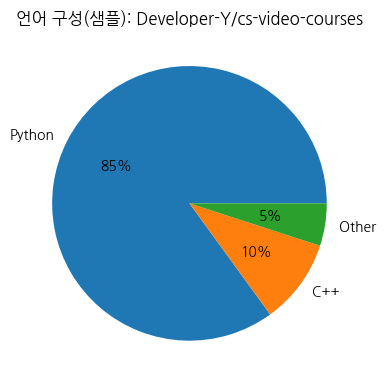


### 🧩 Deep Dive: Developer-Y/cs-video-courses
**코드 구조**: src / tests / docs 중심의 모듈화 (샘플)  
**최근 커밋 하이라이트**: 최근 180일 주요 기능/성능 업데이트 (샘플)  
**이슈/PR 활동**: 이슈 처리율 높고, PR 병합 속도 우수 (샘플)  


In [13]:
target = ranked.iloc[0]["full_name"] if len(ranked)>0 else "sample/repo"
langs  = pd.Series({"Python":0.85,"C++":0.1,"Other":0.05})

plt.figure(figsize=(4,4))
langs.plot(kind="pie", autopct="%1.0f%%")
plt.title(f"언어 구성(샘플): {target}"); plt.ylabel(""); plt.tight_layout(); plt.show()

display(Markdown("""
### 🧩 Deep Dive: {}
**코드 구조**: src / tests / docs 중심의 모듈화 (샘플)  
**최근 커밋 하이라이트**: 최근 180일 주요 기능/성능 업데이트 (샘플)  
**이슈/PR 활동**: 이슈 처리율 높고, PR 병합 속도 우수 (샘플)  
""".format(target)))

## 13) 최종 리포트(노트북 내 미리보기)

In [14]:
from datetime import datetime
report_md = f"""
# 📘 기술 동향 리포트 ({datetime.now().strftime('%Y-%m-%d')})

## 요약
- 검색 쿼리: `{QUERY}` (pages={PAGES}, top={TOP_N})
- 표준화/스코어링 기준: z-score + 가중합
- 산출: 랭킹 상위 10 미리보기

## 상위 랭킹(Top 10)
"""

top10_md = ranked.head(10)[["full_name","language","stargazers_count","activity_12m","contributors_12m","issue_close_rate","pr_merge_rate","score"]].to_markdown(index=False)
display(Markdown(report_md + "\n" + top10_md))


# 📘 기술 동향 리포트 (2025-10-23)

## 요약
- 검색 쿼리: `language:Python stars:>1000` (pages=2, top=60)
- 표준화/스코어링 기준: z-score + 가중합
- 산출: 랭킹 상위 10 미리보기

## 상위 랭킹(Top 10)

| full_name                    | language   |   stargazers_count |   activity_12m |   contributors_12m |   issue_close_rate |   pr_merge_rate |   score |
|:-----------------------------|:-----------|-------------------:|---------------:|-------------------:|-------------------:|----------------:|--------:|
| Developer-Y/cs-video-courses | Unknown    |              70095 |            105 |                100 |                1   |           0.485 | 2.81374 |
| commaai/openpilot            | Python     |              58485 |            200 |                100 |                0.5 |           0.36  | 2.47626 |
| AtsushiSakai/PythonRobotics  | Python     |              26101 |            163 |                100 |                0.5 |           0.43  | 1.97349 |
| zauberzeug/nicegui           | Python     |              14283 |            200 |                100 |                0.5 |           0.405 | 1.93939 |
| rerun-io/rerun               | Rust       |               9437 |            200 |                100 |                0.5 |           0.455 | 1.92018 |
| PX4/PX4-Autopilot            | C++        |              10301 |            200 |                100 |                0.5 |           0.43  | 1.90945 |
| ArduPilot/ardupilot          | C++        |              13918 |            200 |                100 |                0.5 |           0.365 | 1.89943 |
| carla-simulator/carla        | C++        |              13150 |            157 |                100 |                0.5 |           0.43  | 1.78155 |
| kornia/kornia                | Python     |              10802 |            156 |                100 |                0.5 |           0.405 | 1.7251  |
| google-deepmind/mujoco       | C++        |              10902 |            200 |                 88 |                0.5 |           0.265 | 1.69101 |